In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon

In [2]:
ox.config(log_console=True)
ox.__version__

'1.1.1'

In [84]:
# configure the place, network type, trip times, and travel speed
place = "João Pessoa, PB, Brazil"
# configure the place, network type, trip times, and travel speed
network_type = "drive"
trip_times = [25, 50, 75, 100]  # in minutes
travel_speed = 50 # car speed in km/hour (média)

In [85]:
place

'João Pessoa, PB, Brazil'

In [86]:

# download the street network
G = ox.graph_from_place(place, network_type=network_type)


In [87]:
#gdf_nodes = ox.graph_to_gdfs(G, edges=False)
#x, y = gdf_nodes["geometry"].unary_union.centroid.xy
no_hipotetico = ox.distance.nearest_nodes(G, -34.86974, -7.10056)
#G = ox.project_graph(G)

In [88]:


# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["trip_times"] = data["length"] / meters_per_minute



In [89]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

In [90]:
#gdf_nodes = ox.graph_to_gdfs(G, edges=False)
#x, y = gdf_nodes["geometry"].unary_union.centroid.xy
center_node = ox.distance.nearest_nodes(G, -34.86974, -7.10056)
G = ox.project_graph(G)

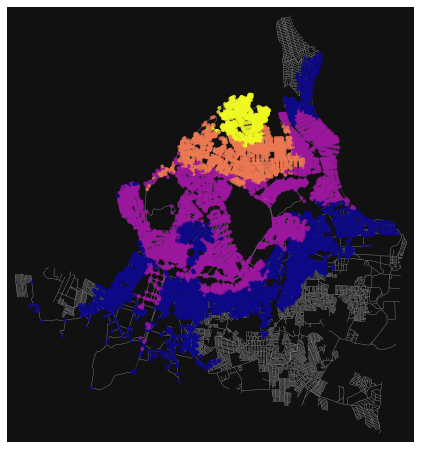

In [91]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)


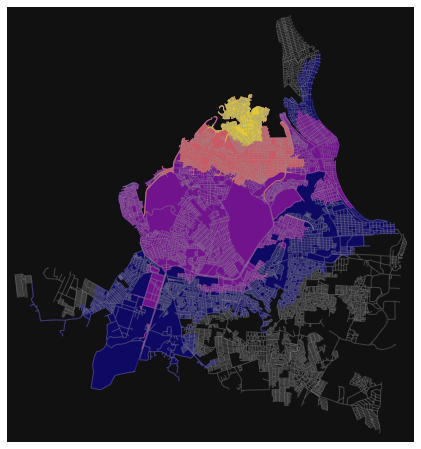

In [92]:
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")

        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union

        # try to fill in surrounded areas so shapes will appear solid and
        # blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys


isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#999999", edge_alpha=0.2, node_size=0
)
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec="none", alpha=0.7, zorder=-1)
    ax.add_patch(patch)
plt.show()



In [64]:
osmnx.stats.edge_length_total(teste)

KeyError: 'all edges must have `length` and `speed_kph` attributes.'

In [82]:
teste = 

(                        y              x  street_count        lon       lat  \
 osmid                                                                         
 324817308  -791940.464110  289608.049182             3 -34.905160 -7.160615   
 7187131525 -792154.311081  289878.580323             3 -34.902719 -7.162558   
 3552601996 -792131.360869  289816.907198             3 -34.903277 -7.162348   
 324817350  -788110.637150  296198.133953             3 -34.845368 -7.126232   
 2052120227 -787999.373549  296374.113088             3 -34.843771 -7.125232   
 ...                   ...            ...           ...        ...       ...   
 8811642853 -798316.105832  295559.337578             3 -34.851523 -7.218478   
 8811642840 -798820.782003  295585.456506             1 -34.851305 -7.223041   
 8811642842 -798843.663582  295646.012956             1 -34.850757 -7.223251   
 8816716318 -795685.028460  295308.532869             4 -34.853696 -7.194681   
 8816716317 -795678.122298  295306.88107